# Self Organizing Maps

## Import

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.5-cp36-none-any.whl size=8474 sha256=dbcbd59b30b1e14df9f3aa27cf06b76760427e28702568ad23ea661be34addf1
  Stored in directory: /root/.cache/pip/wheels/39/5b/16/cc9402ffc58cafb1da6997e5c94b1bde65e8cb214907879fd4
Successfully built minisom


In [0]:
from minisom import MiniSom

## Loading Drive 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
cd drive/My\ Drive/Colab\ Notebooks

# Imshow def

In [0]:
def som_color(data, weights, var_names, *arg):
    assert data.shape[1]>1, 'Not enought variables, need at least 2'

    fig, ax = plt.subplots(nrows=2, ncols=data.shape[1], figsize=(14,10))

    ax[0,0].set_title('SOMs')
    if data.shape[1]<3: # if data shape == 2, adding a dimension to the imshow
        cube  = np.zeros((30,30,3))
        for i in range(data.shape[1]):
            cube[:,:,i] = weights[:,:,i]
        ax[0,0].imshow(cube)
    else:
        ax[0,0].imshow(weights)


    ax[0,1].set_title('distance map ; mean = %.2f' % np.mean(som.distance_map()))
    ax1 = ax[0,1].imshow(som.distance_map())
    #plt.colorbar(ax1,ax=ax[0,1])


    if arg and data.shape[1]>2:
        ax[0,2].set_title('activation response')
        ax2 = ax[0,2].imshow(som.activation_response(data))
        plt.colorbar(ax2,ax=ax[0,2])
        if data.shape[1]>3:
            for i in range(3,data.shape[1]):
                ax[0,i].axis('off')
    else:
        for i in range(2,data.shape[1]):
            ax[0,i].axis('off') # hide subplot


    for i in range(data.shape[1]): # variables plots
        try:
            ax[1,i].set_title(var_names[i])
        except:
            pass
        ax[1,i].imshow(weights[:,:,i])
        ax[1,i].set_axis_off()

    plt.show()

# Colors 

In [0]:
nb=10000

dat1 = np.random.uniform(0,1,nb)
dat2 = np.random.uniform(0,1,nb)
dat3 = np.random.uniform(0,1,nb)

data_color = np.vstack((dat1,
                        dat2,
                        dat3
                        )).T

color_names = ['Red', 'Green', 'Blue']

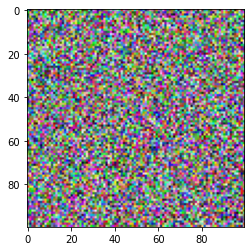

In [242]:
plt.imshow(data_color.reshape(100,100,3));

In [289]:
som_x, som_y = [30,30] # SOMs shape

som = MiniSom(som_x, som_y, data_color.shape[1],
                sigma=8, learning_rate=2)

som.train(data_color, 10000, verbose=True)
print(' topographic error :', som.topographic_error(data_color))

wts_color = som.get_weights()

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.17861953090406474
 topographic error : 0.0154


### Tab 2D

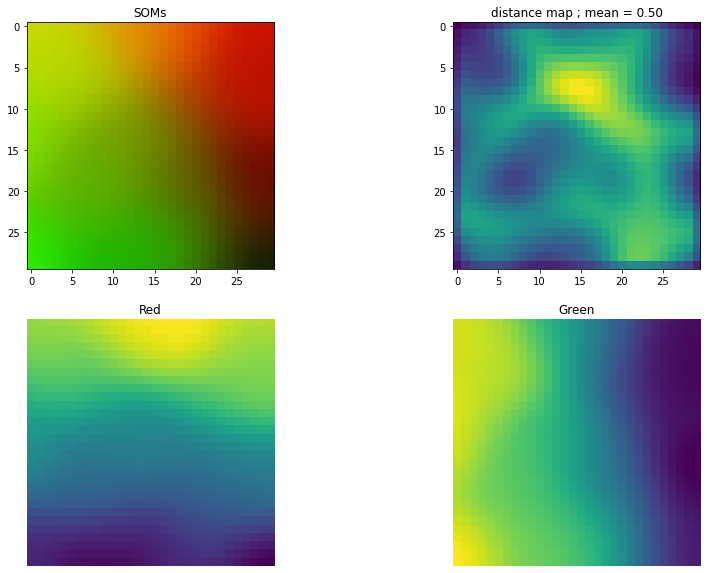

In [269]:
som_color(data_color, wts_color, color_names)

### Tab 3D

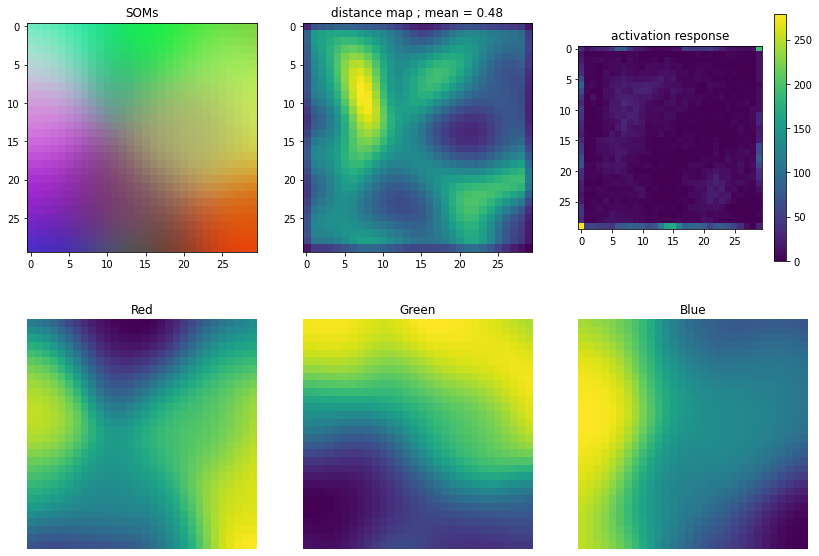

In [273]:
som_color(data_color, wts_color, color_names,True)

# COSMOS dataset

In [0]:
from astropy.io import fits

path_CS_fits = "real_galaxy_catalog_25.2_fits.fits"

with fits.open(path_CS_fits) as hdul:
    hdr = hdul[0].header # header
    data_cs = hdul[1].data # data
    cols = hdul[1].columns # cols 
    Names = cols.names # cols names

In [215]:
hdul.info()

Filename: real_galaxy_catalog_25.2_fits.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   87798R x 14C   [J, D, D, D, 8D, 16D, 5J, D, D, D, J, J, 3D, 4D]   


In [217]:
Names

['IDENT',
 'mag_auto',
 'flux_radius',
 'zphot',
 'sersicfit',
 'bulgefit',
 'fit_status',
 'fit_mad_s',
 'fit_mad_b',
 'fit_dvc_btt',
 'use_bulgefit',
 'viable_sersic',
 'hlr',
 'flux']

In [218]:
def cut_hight_hlr(cat, lim): # delete hlr problems
    idx = np.where(cat['sersicfit'][:,1]>lim)[0]
    print("nb d'elements suppr", idx.shape)
    cat = np.delete(cat,idx)
    return cat

data_cs = cut_hight_hlr(data_cs, 40) # cut hight values

data_cs['sersicfit'][:,1] *= 0.03 # converting hlr

nb d'elements suppr (4041,)


In [0]:
hlr = data_cs['sersicfit'][:,1].copy()
sersic = data_cs['sersicfit'][:,2].copy()
q = data_cs['sersicfit'][:,3].copy()

hlr +=0.03 # converting hlr
sersic /= max(sersic) # normalisation de sersic pour le som

In [220]:
# hlr, sersic, q
choice_cs = np.array([hlr, sersic, q]).T
choice_cs.shape

(83757, 3)

In [221]:
som_x, som_y = [30,30] # SOMs shape

som = MiniSom(som_x, som_y, choice_cs.shape[1],
                sigma=8, learning_rate=2)

som.train(choice_cs, 10000, verbose=True)
print('topographic error :', som.topographic_error(choice_cs))

wts_cs = som.get_weights()

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.1335406928605767
topographic error : 0.01922227395919147


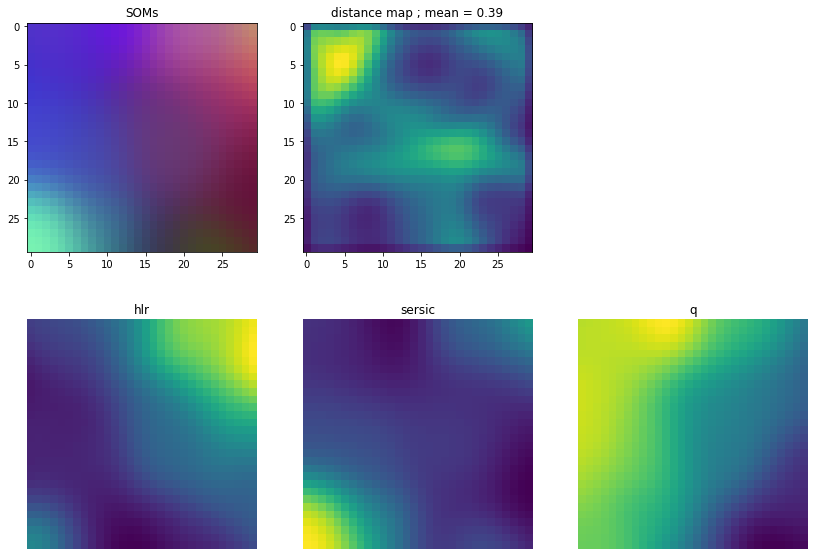

In [202]:
som_color(choice_cs, wts_cs, ['hlr','sersic','q'])

# TU dataset

In [0]:
from astropy.io import fits

path_TU = "TU_created.fits"

with fits.open(path_TU) as hdul:
    hdr = hdul[0].header # header
    data_tu = hdul[1].data # data
    cols = hdul[1].columns # cols
    Names = cols.names # cols names

In [192]:
hdul.info()

Filename: TU_created.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     20   314709R x 6C   [D, D, D, D, D, D]   


In [193]:
Names

['mag', 'half_light_radius', 'q', 'SSersic_n', 'PA', 'bt']

In [194]:
sersic = data_tu['SSersic_n'] / max(data_tu['SSersic_n']) # normalisation de sersic pour le som

hlr_sup1 = np.argwhere(data_tu['half_light_radius']>1) # suppression des elements de hlr > 1

hlr = np.delete(data_tu['half_light_radius'],hlr_sup1)
q = np.delete(data_tu['q'],hlr_sup1)
sersic = np.delete(sersic,hlr_sup1)

len(hlr_sup1) # nombre d'elements supprimes

338

In [195]:
# hlr, sersic, q
choice_tu = np.vstack([hlr,sersic,q]).T
choice_tu.shape

(314371, 3)

In [198]:
som_x, som_y = [30,30] # SOMs shape

som = MiniSom(som_x, som_y, choice_tu.shape[1],
                sigma=8, learning_rate=2)

som.train(choice_tu, 10000, verbose=True)
#print('quantization error :', som.quantization_error(choice_tu))
#print('topographic error :', som.topographic_error(choice_tu))

wts_tu = som.get_weights()

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.07281090106999114


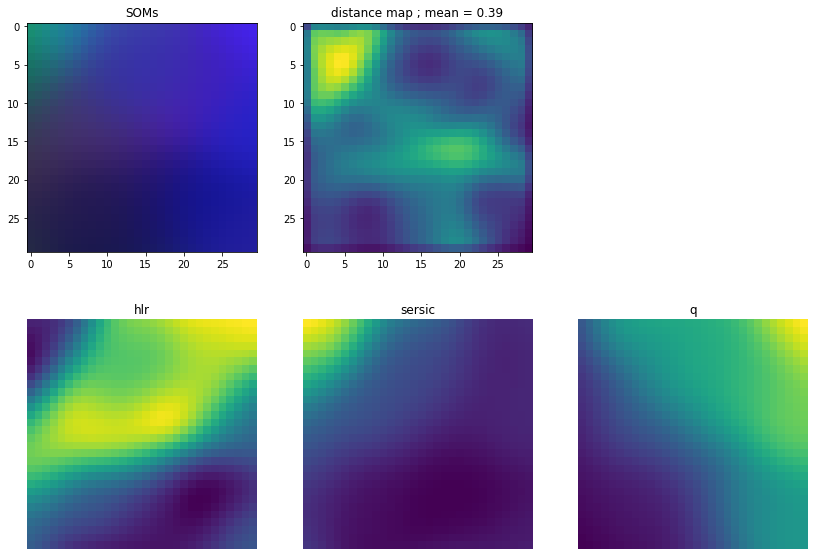

In [201]:
som_color(choice_tu, wts_tu, ['hlr','sersic','q'])